(0.0, 0.1)

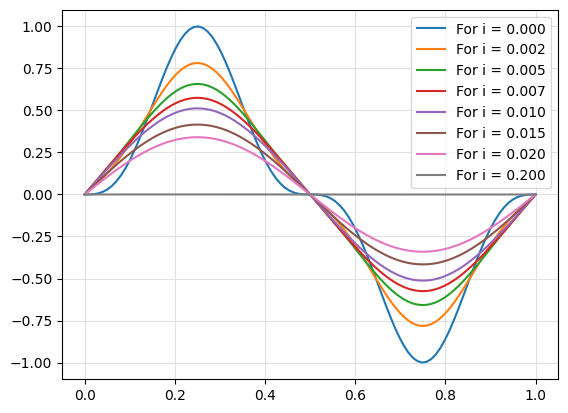

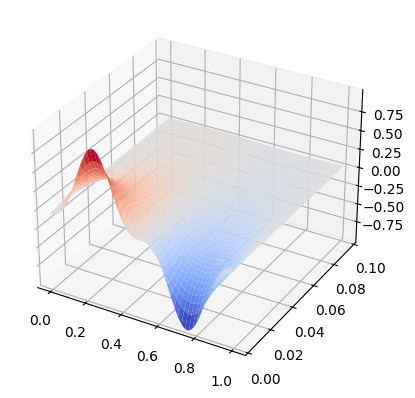

In [59]:
from torch.func import functional_call, grad, vmap, jacrev, hessian
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import math


# problem statement
# init = lambda x: (3/4)*torch.sin(2*math.pi*x) - (1/4)*torch.sin(6*math.pi*x)
init = lambda x: torch.sin(2*math.pi*x)

solution = lambda t, x: (3/4)*torch.exp((-4)*(math.pi**2)*t)*torch.sin(2*math.pi*x) - (1/4)*torch.exp((-36)*(math.pi**2)*t)*torch.sin(6*math.pi*x)
left_boundary = lambda t: 0
right_boundary = lambda t: 0



xs = torch.linspace(0, 1, 100)
for i in torch.cat((torch.linspace(0, 0.01, 5), torch.tensor([0.015, 0.02, 0.2]))):
    ys = solution(torch.full_like(xs, i), xs)
    plt.plot(xs, ys, zorder=2, label=f"For i = {i:.3f}")

# ys = solution(xs, torch.full_like(xs, 0.01))
# plt.plot(xs, ys, zorder=2, label=f"For i = {0}")
plt.grid(c='#e1e1e1', zorder=0)
plt.legend()

mesh = 1000

x = torch.linspace(0, 1, mesh)
t = torch.linspace(0, 0.1, mesh)
T, X = torch.meshgrid(t, x)
data = torch.cartesian_prod(t, x)
# cmap = plt.colormaps['Reds'](28)
_, axes = plt.subplots(1, subplot_kw={"projection": "3d"})

u = solution(T, X)

# u = u.reshape((mesh, mesh))

axes.plot_surface(X, T, u, cmap=plt.cm.coolwarm)
# for xs in ys_to_plot:
#     line = axes.plot(x_train_1d, xs)
#     # line[0].set_color(color)
axes.set_ylim(0, 0.1)
# axes.set_ylim(-1, 1)

In [3]:
# create class for needed thing
class Approximator(nn.Module):
    def __init__(self, *,
                 num_inputs = 2,
                 num_neurons = 5,
                 num_layers = 3,
                 activation = nn.Tanh(),
                 num_outputs = 1):

        super().__init__()

        start_layer = nn.Linear(num_inputs, num_neurons)
        layers = [start_layer, activation]
        for _ in range(num_layers):
            layers.extend([nn.Linear(num_neurons, num_neurons), activation])

        output_layer = nn.Linear(num_neurons, num_outputs)
        layers.append(output_layer)

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = self.network(x)
        return torch.squeeze(x)
        # return self.linear2(x)

torch.manual_seed(42);

In [65]:
from torch import autograd
import torchviz
torch.manual_seed(42)


def phys_loss_fn(xs, y_pred):

    first_derivative = autograd.grad(y_pred, xs, grad_outputs=torch.ones_like(y_pred), create_graph=True, retain_graph=True)[0]
    # We now have dloss/dx
    second_derivative = autograd.grad(first_derivative, xs, grad_outputs=torch.ones_like(first_derivative), create_graph=True, retain_graph=True)[0]

    dudt = first_derivative[:, 0]
    duudxx = second_derivative[:, 1]

    delta_equation = dudt - duudxx
    loss_torch = nn.MSELoss()
    return loss_torch(delta_equation, torch.zeros_like(delta_equation))




# model
# model = Approximator(num_neurons = 128, activation = nn.Sigmoid())
model = Approximator(num_neurons = 6)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_outer = nn.MSELoss()

# data for inner
x_train_1d = torch.rand(300)
x_train_1d_t = torch.rand(300)
# x_train = torch.cartesian_prod(x_train_1d_t, x_train_1d)
x_train = torch.stack((x_train_1d_t, x_train_1d)).T
x_train.requires_grad = True
print(x_train[:5])

# data in init
x_train_init_1d = torch.linspace(0, 1, 20)
x_train_init = torch.stack((torch.zeros_like(x_train_init_1d), x_train_init_1d)).T
y_train_init = init(x_train_init_1d)
print(x_train_init[:5])
print(y_train_init[:5])

# data in left boundary
x_train_left_1d = torch.linspace(0, 1, 5)
x_train_left = torch.stack((x_train_left_1d, torch.full_like(x_train_left_1d, 0))).T
y_train_left = torch.full_like(x_train_left_1d, 0)
print(x_train_left[:5])
print(y_train_left[:5])

# data in right boundary
x_train_right_1d = torch.linspace(0, 1, 5)
x_train_right = torch.stack((x_train_right_1d, torch.full_like(x_train_right_1d, 1))).T
y_train_right = torch.full_like(x_train_right_1d, 0)
print(x_train_right[:5])
print(y_train_right[:5])
# x_train = x_train.T

# all MSE loss
# x_train_mse = torch.cat((x_train_init, torch.cat((x_train_left, x_train_right))))
# print(x_train_mse.shape)
# y_train_mse = torch.cat((y_train_init, torch.cat((y_train_left, y_train_right))))
# print(y_train_mse.shape)

epochs = 4000

for epoch in range(epochs):
    model.train()

    y_pred_inner = model(x_train)
    # y_pred_mse = model(x_train_mse)
    y_pred_init = model(x_train_init)
    y_pred_left = model(x_train_left)
    y_pred_right = model(x_train_right)


    loss_phys = phys_loss_fn(x_train, y_pred_inner)
    # loss_mse = loss_outer(y_pred_mse, y_train_mse)
    loss_init = loss_outer(y_pred_init, y_train_init)
    loss_left = loss_outer(y_pred_left, y_train_left)
    loss_right = loss_outer(y_pred_right, y_train_right)

    loss = 5*loss_init + loss_left + loss_right + loss_phys
    # im = torchviz.make_dot(loss, params=dict(model.named_parameters()))
    # loss = 20*loss_mse + loss_phys
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if epoch % (epochs/10) == 0:
        print(f'Loss phys: {loss_phys:.8f}| loss left: {loss_left:.8f} | loss right: {loss_right:.8f} | loss init: {loss_init:.8f} | Total: {loss}')
        # print(f'Loss phys: {loss_phys:.8f}| loss left: {loss_mse:.8f} | Total: {loss}')
        # with torch.inference_mode():
            # y_pred = model(x_train)
            # _, axes = plt.subplots(1)
            # axes.scatter(x_train_init_1d, y_train_init, c='red')
            # axes.scatter(x_train[:, 1].detach(), y_pred.detach(), label=f'Epoch: {epoch}', alpha = 0.5)
            # axes.set_xlim(0, 1)
            # axes.set_ylim(-1, 1)
            # axes.legend()

# im

tensor([[0.0069, 0.2849],
        [0.0907, 0.4452],
        [0.5966, 0.1258],
        [0.6330, 0.9554],
        [0.6060, 0.1330]], grad_fn=<SliceBackward0>)
tensor([[0.0000, 0.0000],
        [0.0000, 0.0526],
        [0.0000, 0.1053],
        [0.0000, 0.1579],
        [0.0000, 0.2105]])
tensor([0.0000, 0.3247, 0.6142, 0.8372, 0.9694])
tensor([[0.0000, 0.0000],
        [0.2500, 0.0000],
        [0.5000, 0.0000],
        [0.7500, 0.0000],
        [1.0000, 0.0000]])
tensor([0., 0., 0., 0., 0.])
tensor([[0.0000, 1.0000],
        [0.2500, 1.0000],
        [0.5000, 1.0000],
        [0.7500, 1.0000],
        [1.0000, 1.0000]])
tensor([0., 0., 0., 0., 0.])
Loss phys: 0.00009018| loss left: 0.01643018 | loss right: 0.01560354 | loss init: 0.49237537 | Total: 2.4940006732940674
Loss phys: 0.01230950| loss left: 0.17557099 | loss right: 0.09816431 | loss init: 0.26660466 | Total: 1.6190681457519531
Loss phys: 0.04194547| loss left: 0.07847425 | loss right: 0.12519450 | loss init: 0.17527670 | Tot

(-1.0, 1.0)

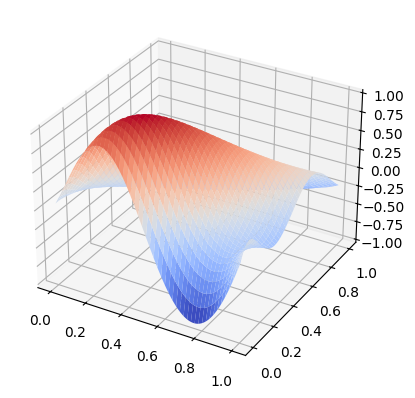

In [66]:
# ys_to_plot = y_pred.detach()
# ys_to_plot = ys_to_plot.reshape(28, 28)
mesh = 1000

x = torch.linspace(0, 1, mesh)
t = torch.linspace(0, 1, mesh)
T, X = torch.meshgrid(t, x)
data = torch.cartesian_prod(t, x)
# cmap = plt.colormaps['Reds'](28)
_, axes = plt.subplots(1, subplot_kw={"projection": "3d"})

with torch.inference_mode():
    u = model(data)

u = u.reshape((mesh, mesh))

axes.plot_surface(X, T, u, cmap=plt.cm.coolwarm)
# for xs in ys_to_plot:
#     line = axes.plot(x_train_1d, xs)
#     # line[0].set_color(color)
axes.set_zlim(-1, 1)
# axes.set_ylim(-1, 1)



In [3]:
import sympy as smp

